# BIKE SHARING DEMAND
The below notebook is to develop a model and discover insights about factors that affect demand in bike sharing using data from Capital Bikeshare.

Data Fields

datetime - hourly date + timestamp    
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter   
holiday - whether the day is considered a holiday  
workingday - whether the day is neither a weekend nor holiday  
weather 1: Clear, Few clouds, Partly cloudy, Partly cloudy   
        2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  
temp - temperature in Celsius  
atemp - "feels like" temperature in Celsius  
humidity - relative humidity  
windspeed - wind speed  
casual - number of non-registered user rentals initiated  
registered - number of registered user rentals initiated  
count - number of total rentals. 

## 1. Import data & libraries

In [125]:
# Import libraries
import klib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
from hyperopt import fmin, tpe, hp,Trials 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PowerTransformer


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn. neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [3]:
# Import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 2. Exploratory Data Analysis

### 2.1 Dataset exploration

There are 10,886 observations in train set with 12 features.   
All features are numeric and 1 datetime feature.  
There is no null data.  
Overall, dataset is already clean.    
After visualize features, we will decide if some transformations may be needed.

In [ ]:
# Data shape
print(train.shape)
print(train.columns)
print(test.shape)
print(test.columns)

(10886, 12)
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')
(6493, 9)
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')


In [ ]:
# Inspect data frame
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# Cast datetime type to datetime columns in train and test set
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [ ]:
train.isnull().mean()

datetime      0.0
season        0.0
holiday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
count         0.0
dtype: float64

We will create new features from datetime columns since prediction will be made for each hour of end-of-month days.

In [5]:
# Create function to transform datetime columns to year, month, day and hour
def time_transform(feat):
    year = feat.dt.year
    month = feat.dt.month
    day = feat.dt.day
    hour = feat.dt.hour
    return year,month,day,hour
    

In [6]:
# Create year, month, day and hour columns for train and test set:
train['year'],train['month'],train['day'],train['hour'] = time_transform(train['datetime'])
test['year'],test['month'],test['day'],test['hour'] =time_transform(test['datetime'])

### 2.2 Visualization

#### 2.2.1 Data distribution

Firstly, we will examine distributions of all numeric features.    
Observation:   
There are some skewed features => power transformation may be needed.  
There are some categorical features which may give some valuable insights such as season, weather, holiday, working day ect.   



Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='hour', ylabel='Density'>

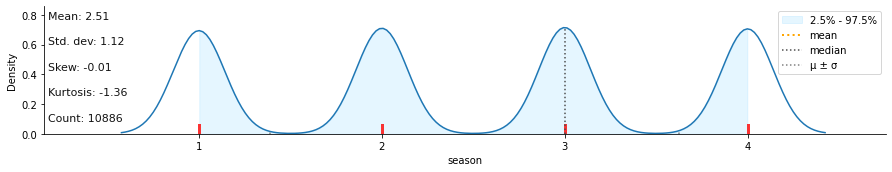

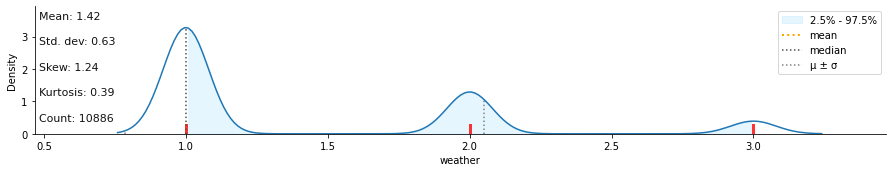

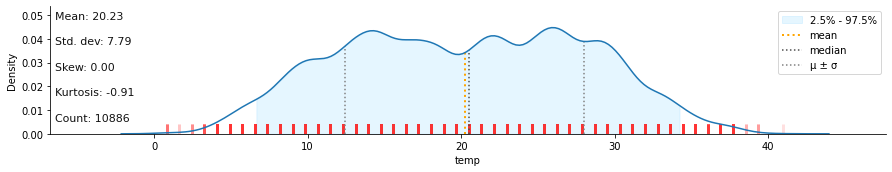

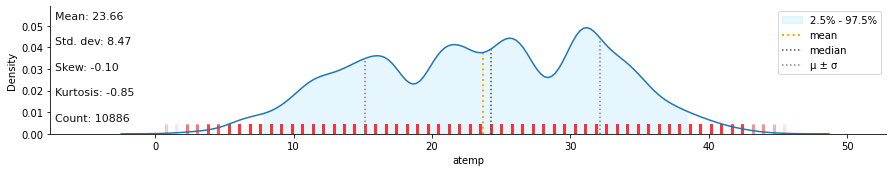

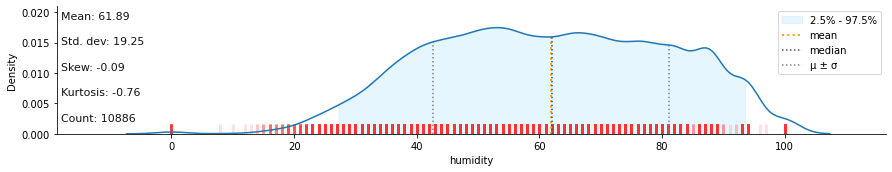

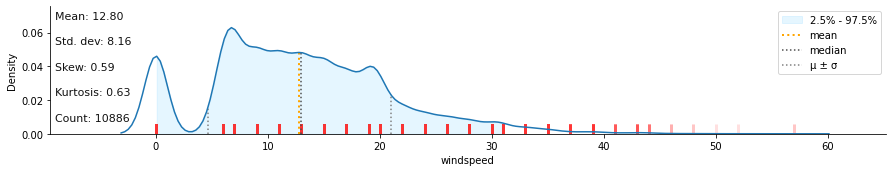

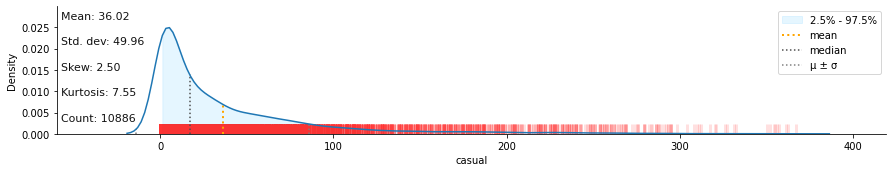

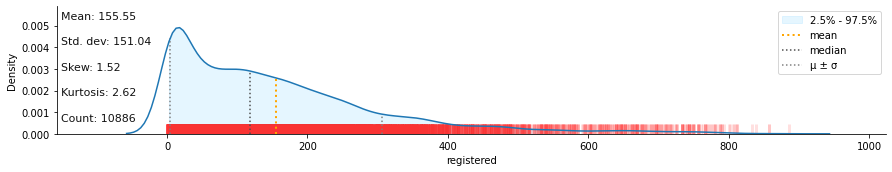

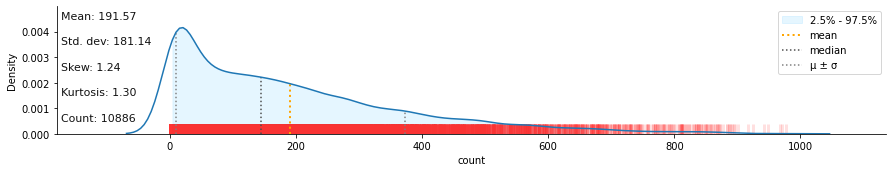

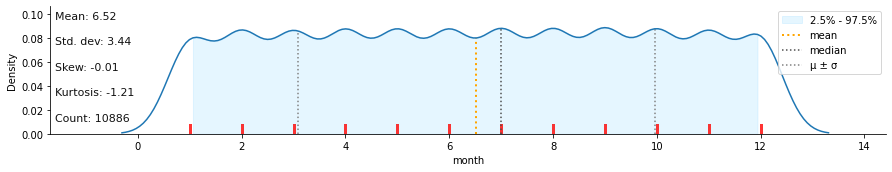

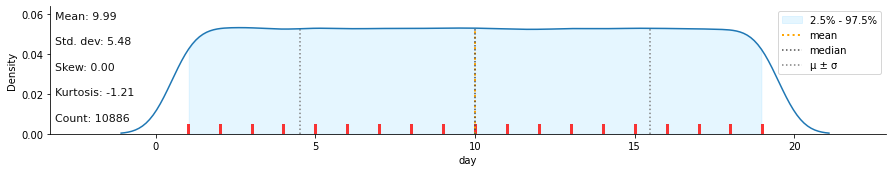

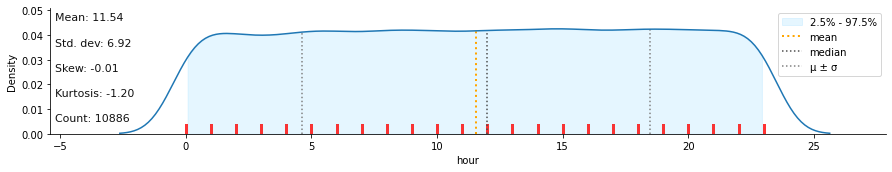

In [ ]:
klib.dist_plot(train)

#### 2.2.2 Relationship 

According to the correlation plot:  
- There are correlations among count, casual and registered, which is reasonable since count is the sum of casual and registered.   
=> Casual and registered will be dropped since prediction is only concerned with count level.
- Month feature is also highly correlation with season.  
=> To give model more information, season will be dropped.  
- atemp and temp with correlation of 0.98.  
=> atemp will be dropped since temp has a slightly higher correlation with target feature.   
- weather and humidity with correlation of 0.41.  
=> weather will be dropped since humidity has higher correlation with target feature.

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

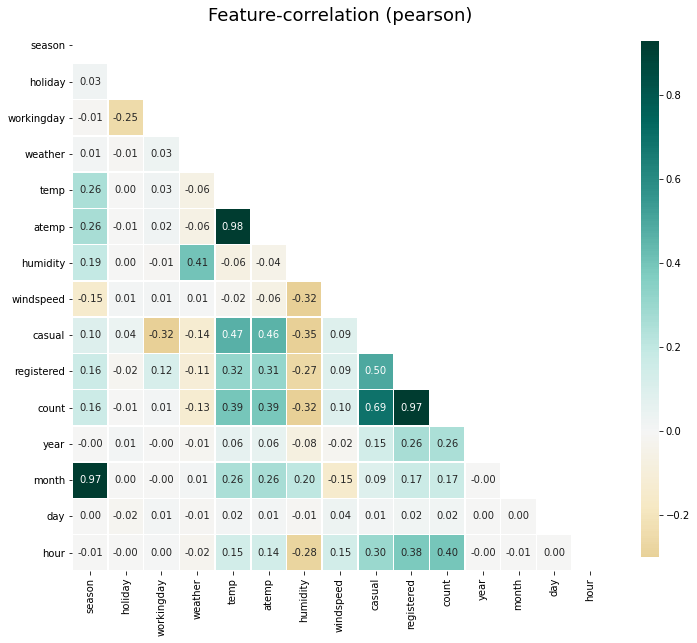

In [ ]:
klib.corr_plot(train)

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

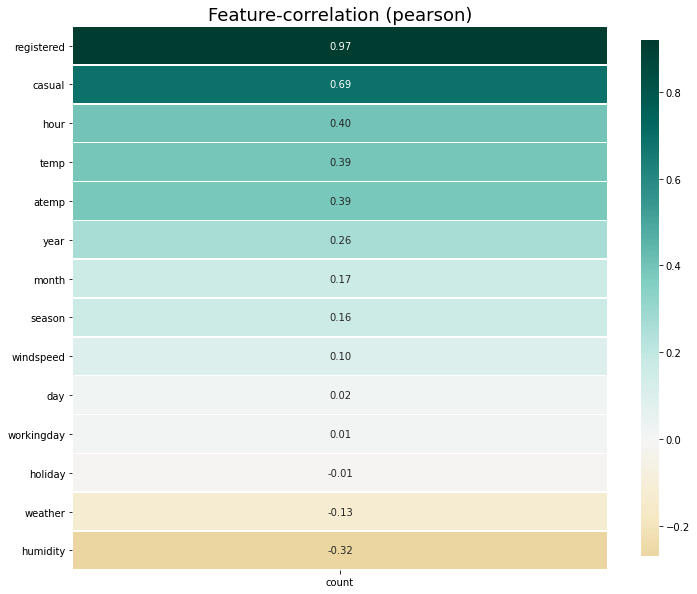

In [ ]:
klib.corr_plot(train,target='count')

#### 2.2.3 Categorical features and target

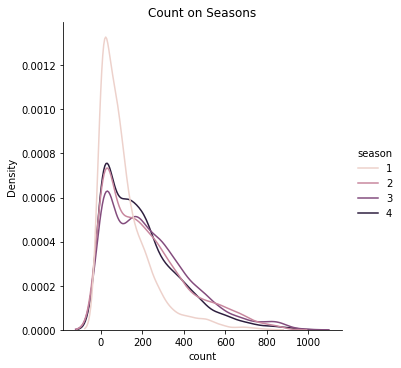

In [ ]:
# Plot density distribution of count for each season
sns.displot(data = train,x='count',hue='season', kind='kde').set(title ='Count on Seasons')
plt.show()


From the plot, it's shown that density distribution of count in season 1(spring) is different from the rest which indicates the lower rental in spring comparing to other seasons. 

The H-test below shows that there is a difference in count feature in 4 seasons. 

In [ ]:
# Perform hypothesis test to confirm 
# Create 4 test samples 
spring = train[train['season']==1]['count']
summer = train[train['season']==2]['count']
fall   = train[train['season']==3]['count']
winter = train[train['season']==4]['count']
# Perform H-test for 4 samples (not normally distributed)
h_test = stats.kruskal(spring,summer,fall,winter)
print(h_test)



KruskalResult(statistic=699.6668548181988, pvalue=2.479008372608633e-151)


Distributions of count in 4 type of weathers also differ. There are more rental for weather in good condition.

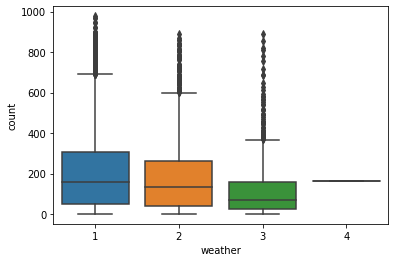

In [ ]:
sns.boxplot(data=train,x='weather',y='count').set(label ='Weather on count')
plt.show()

Bike rental does not seem to be different in either holiday, weekend or weekdays.  
The hypothesis is observed from the boxplot below and then confirmed using hypothesis test.

In [ ]:
# Plot density distribution of count for each season
sns.displot(data = train,x='count',hue='workingday', kind='kde').set(title ='Count on Working day')
plt.show()

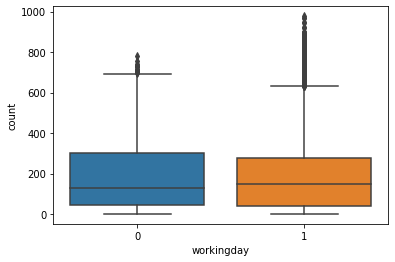

In [ ]:
sns.boxplot(data=train,x='workingday',y='count').set(label ='Working day on count')
plt.show()

In [ ]:
work = train[train['workingday']==1]['count']
not_work = train[train['workingday']==0]['count']
wilc = stats.ranksums(work,not_work)
print(wilc)

RanksumsResult(statistic=-0.04022750306106067, pvalue=0.9679117511000895)


### 2.3 Feature Engineering

Drop unnecessary columns for train, and test sets.  
Create validation set from train set

In [7]:
# drop columns on train and test set
train_com = train.drop(['datetime','season','atemp','weather','casual','registered','day'], axis=1)
test_com = test.drop(['datetime','season','atemp','weather','day'],axis=1)

In [8]:
# create train and validation test
X_train, X_val, y_train,y_val = train_test_split(train_com.drop('count', axis=1), train_com['count'],test_size=0.3)

Transform winspeed column which is under a skewed distribution on train,validation and test sets.

In [142]:
# Create power transformer object
transformer = PowerTransformer(method='yeo-johnson')

In [143]:
# Fit transformer on train set then transform
transformer.fit(X_train[['windspeed']])
X_train['windspeed_tf'] =transformer.transform(X_train[['windspeed']])
X_val['windspeed_tf']= transformer.transform(X_val[['windspeed']])
test_com['winspeed_tf'] = transformer.transform(test_com[['windspeed']])

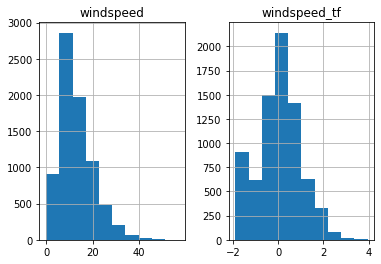

In [ ]:
X_train[['windspeed', 'windspeed_tf']].hist()
plt.show()

In [144]:
# Drop winspeed columns
X_train_tf = X_train.drop('windspeed', axis=1)
X_val_tf =X_val.drop('windspeed', axis=1)
X_test_tf = test_com.drop('windspeed',axis=1)

In [ ]:
X_train_tf.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'year', 'month', 'hour',
       'windspeed_tf'],
      dtype='object')

## 3. Modelling

### 3.1 Baseline

In this section, we will run different classifiers to identity which learner will have the best performance

In [ ]:
# Instantiate models for baseline selection

models=[]
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('EN', ElasticNet()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('Ada',AdaBoostRegressor()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('xgb',xgb.XGBRegressor(objective ='reg:linear')))

In [16]:
# Create RMSLE score function:
def rmsle_score(preds, true):
    rmsle_score = (np.sum((np.log1p(preds)-np.log1p(true))**2)/len(true))**0.5
    return rmsle_score
# Create RMSLE score function for cross_val_score
RMSLE = make_scorer(rmsle_score)

Perform 10 cv on different classifiers:

In [ ]:
# Cross validate models
clfs=[]
cv_results =[]
train_results=[]
val_results=[]

for name, model in models:
    clfs.append(name)

    # Cross validate on train set
    cv_result = cross_val_score(model, X_train_tf,y_train, cv=10, scoring= RMSLE)
    # Append result to result list
    cv_results.append(cv_result)

    # Compute error on the train set
    learner = model.fit(X_train_tf,y_train)
    train_result = rmsle_score(learner.predict(X_train_tf),y_train)
    train_results.append(train_result)

    # Compute error on the validation set
    val_result = rmsle_score(learner.predict(X_val_tf), y_val)
    val_results.append(val_result)

    table = "%s: %f (%f) %f %f"%(name, cv_result.mean(), cv_result.std(), train_result, val_result)
    print(table)

Visualize cross-validation results:  
From the plot, it seems that tree-based models have better performance than linear models. 

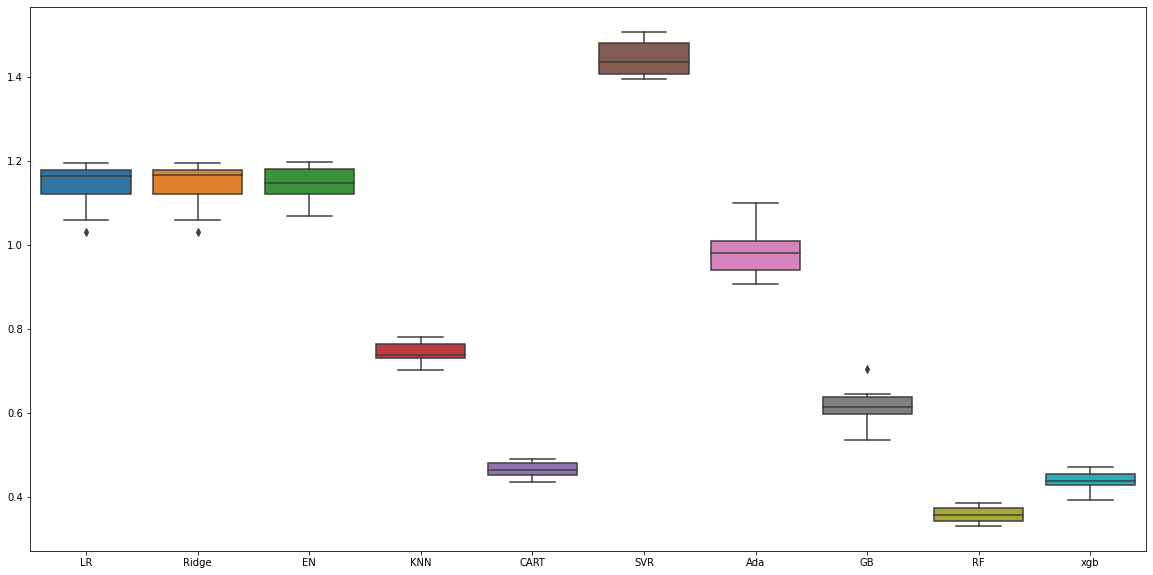

In [ ]:
#Create cv_df
cv_df = pd.DataFrame(data= cv_results, index=clfs).T

#Visualize cross-validation results
plt.figure(figsize=(20,10))
sns.boxplot(data=cv_df)
sns.set_style('darkgrid')

Visualize train and validation error:   
The best candidates here are Random Forest and XGBoost.  

In conclusion, after comparing the result of 2 plots, Random Forest will be choosen as the baseline model.

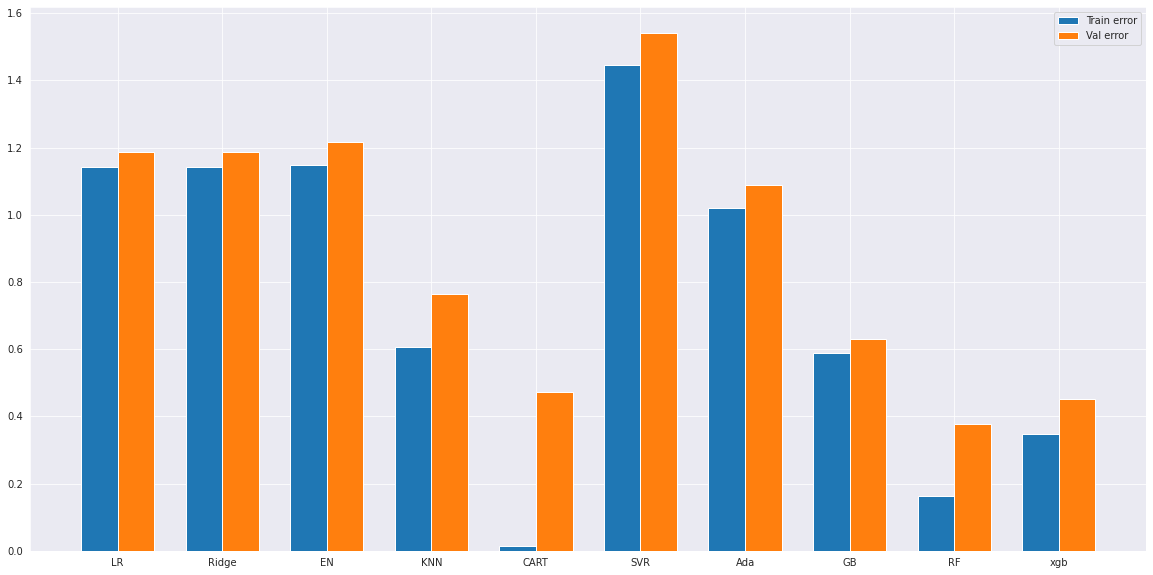

In [ ]:
# Visualize train, test error

fig = plt.figure()
ax=fig.add_subplot()
ind = np.arange(len(clfs)) 
width=0.35
plt.bar(ind - width/2 ,train_results,width=width, label='Train error')
plt.bar(ind + width/2, val_results, width=width, label='Val error')
plt.legend()
fig.set_size_inches(20,10)
ax.set_xticks(ind)
ax.set_xticklabels(clfs)
plt.show()

### 3.2 Feature importance
        Using feature importance attribute from Random Forest, it is suggested that hour is the most important feature, followed by temp, year and working day.

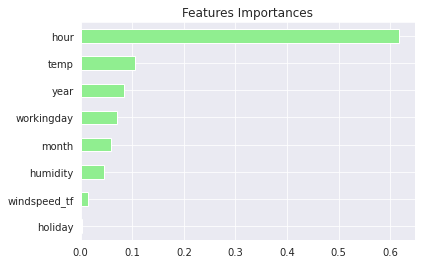

In [ ]:
# Create a pd.Series of features importances
importances = pd.Series(data=models[8][1].feature_importances_,
                        index=X_train_tf.columns )

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

## 4. Finalise model

In [161]:
# Instantiate model 
rf = RandomForestRegressor(random_state=40, n_estimators =400, max_features=7, min_samples_split=0.001, min_samples_leaf=0.0001)

In [162]:
# Fit model to transformed train set 
rf.fit(X_train_tf, y_train)
# Predict on transformed validation set
pred = rf.predict(X_val_tf)
rmsle = rmsle_score(pred, y_val).mean()
print(rmsle)


0.3649315567192838


In [174]:
# Predict on test set
prediction = np.around(rf.predict(X_test_tf))

In [177]:
# Create submission file
test['count'] = prediction
submission =test[['datetime','count']]
submission.to_csv('submission.csv', index=False)

## 5. Conclusion

- Hour and temperature are the most important features that affect bike sharing demand according to model.  
- Statistically, season and weather also contribute to the market demand while suprisingly, the demand does not seem to be affected by whether it is working day or holiday/weekend period. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a5eb6ddb-4b9a-43e6-963b-aa328e87c48d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>